### Introducción: Métricas para Evaluar la Predicción Meteorológica

Las métricas juegan un rol fundamental en la evaluación de modelos de predicción meteorológica, especialmente en un contexto de comparación entre métodos tradicionales de predicción numérica y enfoques basados en machine learning (ML). Estas herramientas permiten cuantificar el desempeño de los modelos al analizar tanto su precisión general como su capacidad para predecir fenómenos extremos y variaciones espaciales.

#### Principales Métricas de Evaluación

1. **RMSE (Root Mean Square Error):**  
   - **Definición:** Mide la magnitud promedio de los errores entre las predicciones y los valores observados. 
   - **Importancia:** Evalúa la precisión general del modelo, penalizando fuertemente los errores grandes. En meteorología, se pondera por el coseno de la latitud para reflejar la geometría esférica de la Tierra.
   - **Aplicación:** Es ampliamente utilizada en estudios de predicción para validar variables clave como temperatura y altura geopotencial.

2. **Bias (Sesgo):**  
   - **Definición:** Calcula la diferencia promedio entre las predicciones y los valores observados. 
   - **Importancia:** Un sesgo positivo o negativo indica si el modelo tiende a sobreestimar o subestimar las observaciones. En predicción meteorológica, el sesgo ponderado por latitud permite ajustar el análisis a la distribución espacial de los datos.
   - **Uso común:** Es crítico para entender errores sistemáticos, especialmente en horizontes temporales largos.

3. **ACC (Anomaly Correlation Coefficient):**  
   - **Definición:** Mide la correlación entre las anomalías (desviaciones de la media) de las predicciones y los valores observados.
   - **Relevancia:** Captura la habilidad del modelo para replicar patrones de variación en el clima, más allá de los valores absolutos. Es especialmente útil para evaluar eventos extremos.
   - **Ponderación:** También se ajusta por latitud, asegurando que regiones con menos densidad de datos no sean subrepresentadas.

#### Contexto en Predicción Meteorológica
Estas métricas, adaptadas de la práctica operativa y estudios como *"The Rise of Data-Driven Weather Forecasting"*, permiten:
- **Evaluar precisión global:** Comparar modelos tradicionales y de ML en términos de predicción media.
- **Analizar eventos extremos:** Verificar la habilidad del modelo para predecir fenómenos de alta intensidad, como ciclones tropicales o variaciones de temperatura extremas.
- **Identificar fortalezas y limitaciones:** Explorar tendencias sistemáticas y áreas donde los modelos pueden fallar, como la predicción de estructuras a pequeña escala o fenómenos no presentes en los datos de entrenamiento.



In [4]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc").isel(time=slice(0,30))
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset




c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 381MB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 30)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 240B 2014-01-01 2014-01-02 ... 2014-01-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 381MB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#importar variable 
lsm=xr.open_dataset("D://Aaron//datos_mascara.nc") 

In [7]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Filtrar por la profundidad (limitando el número de niveles de profundidad)
N = 10 #en 10 debe de estar,cambiando a menos dura mes el entreno pero peta
dataset = dataset.isel(depth=slice(0, N)) #voy a probar a coger todas
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset, reemplazando los NaNs con ceros para evitar problemas
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset = dataset.assign(lsm=lsm_interp_clean['lsm'])



# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])

# Verificar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    """
    Verifica y ajusta las latitudes del dataset para asegurar que estén en orden correcto y sin problemas.

    Args:
        dataset (xr.Dataset): Dataset que contiene la información de latitudes.

    Returns:
        xr.Dataset: Dataset con las latitudes verificadas y reordenadas si es necesario.
    """   
    latitude = dataset['latitude'].values
    is_strictly_decreasing = np.all(np.diff(latitude) < 0)
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not is_strictly_decreasing:
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    """
    Verifica y ajusta las longitudes del dataset para asegurar que estén dentro del rango [0,360].

    Args:
        dataset (xr.Dataset): Dataset que contiene la información de longitudes.

    Returns:
        xr.Dataset: Dataset con las longitudes ajustadas sumándoles 360 a todas.
    """
    longitude = dataset['longitude'].values
    
    longitude = longitude + 360
    
    dataset = dataset.assign_coords(longitude=longitude)
    
    return dataset

# Llamar a las funciones para verificar las latitudes y longitudes
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)


latitude = torch.from_numpy(dataset['latitude'].values).float().to(device)
longitude = torch.from_numpy(dataset['longitude'].values).float().to(device)
# Revisar si hay valores NaN restantes después de la interpolación
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")



In [8]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [9]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


In [10]:
num_times = len(dataset['time'])

# Definir proporciones asegurando tamaños mínimos
sample_size = 3  # Tamaño de muestra

train_size = int(num_times * 0.7)
test_size = sample_size + 1  
val_size = num_times - train_size - test_size

# Si val_size es menor que sample_size + 1, ajustar train_size
if val_size < sample_size + 1:
    train_size -= (sample_size + 1 - val_size)
    val_size = sample_size + 1

# Dividir el conjunto de datos
train_dataset = dataset.isel(time=slice(0, train_size))
val_dataset = dataset.isel(time=slice(train_size, train_size + val_size))
test_dataset = dataset.isel(time=slice(train_size + val_size, num_times))

In [11]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [12]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


### Configuración del Optimizador y Criterios de Pérdida

In [10]:
import torch
import torch.optim as optim

# Cambiar el optimizador a AdamW, recomendado en el paper
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.L1Loss(reduction='none')

model.train()
model.configure_activation_checkpointing()




###  Función de entrenamiento

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def train(
    model, 
    train_dataset, 
    val_dataset, 
    batch_size, 
    num_epochs, 
    criterion, 
    optimizer, 
    sample_size, 
    device
):
    """
    Entrena el modelo y calcula las pérdidas en entrenamiento y validación.
    """
    # Generadores de batches para entrenamiento y validación
    train_generator = BatchGenerator(train_dataset, sample_size, batch_size, shuffle=True, padding=True)
    val_generator = BatchGenerator(val_dataset, sample_size, batch_size, shuffle=False, padding=False)

    # Listas para almacenar pérdidas
    train_losses = []
    val_losses = []

    # Inicializar el escalador para AMP
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_batches = 0

        for batch, batch_target in tqdm(train_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Train"): 
            optimizer.zero_grad()

            if getattr(batch.metadata, 'is_padding', False):
                continue

            # Obtener el target y moverlo al dispositivo
            target = batch_target.surf_vars['thetao'].to(device)  # Shape: (batch_size, 1, lat, lon)

            with autocast(device_type=device.type):
                # Obtener las predicciones del modelo
                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']  # Shape: (batch_size, 1, lat, lon)

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch
                loss = loss_per_sample.mean()

            # Backpropagación
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Acumular la pérdida
            train_loss += loss.item()
            total_batches += 1

        # Promediar la pérdida del entrenamiento
        if total_batches > 0:
            average_train_loss = train_loss / total_batches
            train_losses.append(average_train_loss)
        else:
            train_losses.append(0)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}")

        # Validación
        model.eval()
        val_loss = 0.0
        total_val_batches = 0

        with torch.no_grad():
            for batch, batch_target in tqdm(val_generator, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                if getattr(batch.metadata, 'is_padding', False):
                    continue

                target = batch_target.surf_vars['thetao'].to(device)

                outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
                model_output = outputs[0]
                output_tensor = model_output.surf_vars['thetao']

                # Calcular la pérdida sin reducción
                loss_matrix = criterion(output_tensor, target)  # Shape: (batch_size, 1, lat, lon)

                # Promediar en latitud y longitud para obtener la pérdida por muestra
                loss_per_sample = loss_matrix.mean(dim=[2, 3])  # Shape: (batch_size, 1)
                loss_per_sample = loss_per_sample.squeeze(1)     # Shape: (batch_size,)

                # Calcular la pérdida total del batch.
                loss = loss_per_sample.mean()

                val_loss += loss.item()
                total_val_batches += 1

        # Promediar la pérdida de validación
        if total_val_batches > 0:
            average_val_loss = val_loss / total_val_batches
            val_losses.append(average_val_loss)
        else:
            val_losses.append(0)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_losses[-1]:.6f}")

    return train_losses, val_losses




In [12]:
# Parámetros para el entrenamiento
batch_size = 3
sample_size = 3
num_epochs = 1



# Ejecutar el entrenamiento con validación y cálculo de RMSE
train_losses, val_losses = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    criterion=criterion,
    optimizer=optimizer,
    sample_size=sample_size,
    device=device,
)




Epoch 1/1 - Train: 0it [00:00, ?it/s]c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)
c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\torch\utils\checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Epoch 1/1 - Train: 7it [04:17, 36.75s/it]


Epoch 1/1, Train Loss: 0.401901


Epoch 1/1 - Validation: 1it [00:17, 17.44s/it]

Epoch 1/1, Validation Loss: 0.206044


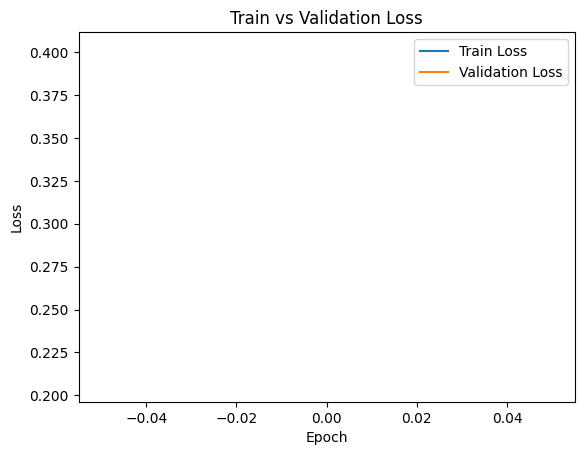

In [13]:
# Graficar las pérdidas
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

### Guardar el modelo

In [14]:

torch.save(model, 'C:/Users/Victor/deep_ocean/TFG_victor/saved_models/modelo_aurora_prueba_metricas.pth')




In [14]:
model = torch.load('C:/Users/Victor/deep_ocean/TFG_victor/saved_models/modelo_aurora_prueba_metricas.pth')
model.eval()
batch_size = 3

# Create a BatchGenerator for the test dataset
test_generator = BatchGenerator(test_dataset, sample_size=3, batch_size=batch_size, shuffle=False, padding=False)

# Lists to store predictions, targets, and timestamps
predictions = []
targets = []
timestamps = []

# Perform inference and collect predictions
for batch, batch_target in test_generator:
    # Move batch to device
    if getattr(batch.metadata, 'is_padding', False):
        continue  # Skip padding batches if any

    target = batch_target.surf_vars['thetao'].to(device)
    targets.append(target.cpu().numpy())
    timestamps.extend(batch.metadata.time)

    with torch.no_grad():
        outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
        model_output = outputs[0]
        prediction = model_output.surf_vars['thetao'].cpu().numpy()
        predictions.append(prediction)


C:\Users\Victor\AppData\Local\Temp\ipykernel_4084\3408016398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('C:/Users/Victor/deep_ocean/TFG_victor/sa

# Métricas basandonos en el artículo: The rise of Data-Driven Weather Forecasting
---

Antes de calcular las métricas, necesitamos preparar los datos: predicciones, valores reales (targets) y las latitudes correspondientes.

#### Cargar las predicciones y los targets

In [15]:

all_predictions = np.concatenate(predictions, axis=0).squeeze(axis=1)  # Forma: (num_samples, lat, lon)
all_targets = np.concatenate(targets, axis=0).squeeze(axis=1)          # Forma: (num_samples, lat, lon)

print(f"Forma de all_predictions: {all_predictions.shape}")
print(f"Forma de all_targets: {all_targets.shape}")

Forma de all_predictions: (2, 180, 180)
Forma de all_targets: (2, 180, 180)


**Salida esperada:**

Forma de all_predictions: (num_samples, lat, lon)

Forma de all_targets: (num_samples, lat, lon)

#### Obtener las latitudes

In [16]:
# Obtener las latitudes del dataset
latitudes = dataset['latitude'].values  # Forma: (lat,)

print(f"Forma de latitudes: {latitudes.shape}")
print(f"Primeras 5 latitudes: {latitudes[:5]}")


Forma de latitudes: (180,)
Primeras 5 latitudes: [34.5      34.416668 34.333332 34.25     34.166668]


### RMSE (Root Mean Square Error) ponderado por latitud
El RMSE mide el error cuadrático medio entre las predicciones y los valores reales, ponderado por el coseno de la latitud.

#### Paso 1: Convertir las latitudes a radianes y calcular los pesos

In [40]:
# Convertir latitudes de grados a radianes
lat_rad = np.deg2rad(latitudes)
print(f"Latitudes en radianes: {lat_rad[:5]}")  # Mostrar las primeras 5 latitudes en radianes

# Calcular los pesos usando el coseno de la latitud
weights = np.cos(lat_rad)
print(f"Pesos sin normalizar: {weights[:5]}")  # Mostrar los primeros 5 pesos




Latitudes en radianes: [0.6021386  0.60068417 0.5992297  0.5977753  0.59632087]
Pesos sin normalizar: [0.8241262  0.8249491  0.8257703  0.82658976 0.8274074 ]


#### Paso 2: Normalizar los pesos
Aplicamos la normalización dividiendo cada peso por el promedio de todos los pesos:

In [39]:
# Calcular el factor de normalización
normalization_factor = np.mean(weights)
print(f"Factor de normalización: {normalization_factor}")

# Normalizar los pesos
weights_normalized = weights / normalization_factor
print(f"Pesos normalizados: {weights_normalized[:5]}")  # Mostrar los primeros 5 pesos normalizados


Factor de normalización: 0.888134777545929
Pesos normalizados: [0.92792916 0.9288557  0.9297804  0.93070304 0.9316237 ]


**Salida esperada:**
Factor de normalización: 0.8860357999801636
Pesos normalizados: [0.93009686 0.9310137  0.9319296  0.93284404 0.9337578 ]


**Salida esperada:**
Latitudes en radianes: [0.6021386  0.60068417 0.5992297  0.5977753  0.59632087]
Pesos sin normalizar: [0.8241262  0.8249491  0.8257703  0.82658976 0.8274074 ]


#### Paso 3: Ajustar la forma de los pesos para que coincida con las predicciones y targets

Debemos asegurarnos de que los pesos tengan la misma forma que nuestras predicciones y targets.



In [ ]:

# Reshape de los pesos para que tengan forma (1, lat, 1)
weights_normalized = weights_normalized.reshape(1, -1, 1)
print(f"Forma de weights_normalized después del reshape: {weights_normalized.shape}")



Forma de weights_normalized después del reshape: (1, 180, 1)


**Salida esperada:**

Forma de weights después del reshape: (1, lat, 1)

#### Paso 4: Expandir los pesos para que coincidan con la forma de predicciones y targets

In [42]:

# Expandir los pesos para que tengan la misma forma que las predicciones y targets
weights_full = np.tile(weights_normalized, (all_predictions.shape[0], 1, all_predictions.shape[2]))
print(f"Forma de weights_full: {weights_full.shape}")


Forma de weights_full: (2, 180, 180)


**Salida esperada:**

Forma de weights_full: (num_samples, lat, lon)

#### Paso 5: Verificar valores mínimos y máximos de los pesos normalizados


In [44]:
print(f"Valores mínimos y máximos de los pesos normalizados: {weights_normalized.min()}, {weights_normalized.max()}")


Valores mínimos y máximos de los pesos normalizados: 0.927929162979126, 1.0608243942260742


#### Paso 6: Calcular el RMSE ponderado

In [45]:
# Calcular los errores cuadrados
squared_errors = (all_predictions - all_targets) ** 2
print(f"Errores cuadrados (primeros 5 valores):\n{squared_errors.flatten()[:5]}")



Errores cuadrados (primeros 5 valores):
[0.03022683 0.00607494 0.00085652 0.00030899 0.00769261]


#### Paso 7: Aplanar los arrays y aplicar máscara para NaNs



In [46]:
# Aplanar los arrays
squared_errors_flat = squared_errors.reshape(-1)
weights_flat = weights_full.reshape(-1)

# Crear una máscara para eliminar valores NaN
valid_mask = ~np.isnan(squared_errors_flat) & ~np.isnan(weights_flat)

# Aplicar la máscara
squared_errors_flat = squared_errors_flat[valid_mask]
weights_flat = weights_flat[valid_mask]

print(f"Tamaño después de eliminar NaNs: {squared_errors_flat.size}")



Tamaño después de eliminar NaNs: 64800


#### Paso 8: Calcular el RMSE ponderado usando np.average

In [47]:
# Calcular la media ponderada de los errores cuadrados
mse_weighted = np.average(squared_errors_flat, weights=weights_flat)
rmse_weighted = np.sqrt(mse_weighted)
print(f"RMSE ponderado: {rmse_weighted}")



RMSE ponderado: 0.3188740015029907


## Calculo del Bias ponderado

#### Paso 1: Calcular las diferencias entre predicciones y targets

In [48]:
# Calcular las diferencias
differences = all_predictions - all_targets
print(f"Diferencias (primeros 5 valores):\n{differences.flatten()[:5]}")



Diferencias (primeros 5 valores):
[ 0.17385864  0.07794189  0.02926636 -0.01757812 -0.08770752]


#### Paso 2: Aplanar los arrays y aplicar máscara para NaNs

In [49]:
# Aplanar los arrays
differences_flat = differences.reshape(-1)
weights_flat = weights_full.reshape(-1)

# Crear una máscara para eliminar valores NaN
valid_mask = ~np.isnan(differences_flat) & ~np.isnan(weights_flat)

# Aplicar la máscara
differences_flat = differences_flat[valid_mask]
weights_flat = weights_flat[valid_mask]

print(f"Tamaño después de eliminar NaNs: {differences_flat.size}")


Tamaño después de eliminar NaNs: 64800


#### Paso 2: Calcular el numerador y denominador para el Bias ponderado

In [28]:
# Calcular el numerador: suma de las diferencias ponderadas
numerator_bias = np.sum(weights_full * differences)

# Calcular el denominador: suma de los pesos (ya calculado anteriormente)
# denominator_bias = denominator (del RMSE)

print(f"Numerador (suma de diferencias ponderadas): {numerator_bias}")
print(f"Denominador (suma de pesos): {denominator}")  # Reutilizamos el denominador del RMSE


Numerador (suma de diferencias ponderadas): 5100.748046875
Denominador (suma de pesos): 57551.1328125


#### Paso 3: Calcular el Bias ponderado usando np.average

In [50]:

# Calcular el Bias ponderado
bias_weighted = np.average(differences_flat, weights=weights_flat)
print(f"Bias ponderado: {bias_weighted}")



Bias ponderado: 0.0886298418045044


## Calculo del ACC ponderado

#### Paso 1: Aplanar los arrays y aplicar máscara para NaNs

In [51]:
# Aplanar los arrays
pred_flat = all_predictions.reshape(-1)
target_flat = all_targets.reshape(-1)
weights_flat = weights_full.reshape(-1)

# Crear una máscara para eliminar valores NaN
valid_mask = ~np.isnan(pred_flat) & ~np.isnan(target_flat) & ~np.isnan(weights_flat)

# Aplicar la máscara
pred_flat = pred_flat[valid_mask]
target_flat = target_flat[valid_mask]
weights_flat = weights_flat[valid_mask]

print(f"Tamaño después de eliminar NaNs: {pred_flat.size}")


Tamaño después de eliminar NaNs: 64800


#### Paso 2: Calcular las medias ponderadas

In [52]:
# Calcular las medias ponderadas
pred_mean = np.average(pred_flat, weights=weights_flat)
target_mean = np.average(target_flat, weights=weights_flat)

print(f"Media ponderada de las predicciones: {pred_mean}")
print(f"Media ponderada de los targets: {target_mean}")



Media ponderada de las predicciones: 292.1131591796875
Media ponderada de los targets: 292.0245361328125


#### Paso 3: Calcular las anomalías

In [53]:
# Calcular las anomalías
pred_anomaly = pred_flat - pred_mean
target_anomaly = target_flat - target_mean

print(f"Anomalías de predicciones (primeros 5): {pred_anomaly[:5]}")
print(f"Anomalías de targets (primeros 5): {target_anomaly[:5]}")



Anomalías de predicciones (primeros 5): [-0.23565674 -0.29934692 -0.28430176 -0.30917358 -0.49502563]
Anomalías de targets (primeros 5): [-0.32089233 -0.28866577 -0.22494507 -0.20297241 -0.31869507]


#### Paso 4: Calcular covarianza y varianzas ponderadas

In [56]:
# Calcular la covarianza ponderada
covariance = np.average(pred_anomaly * target_anomaly, weights=weights_flat)
print(f"Covarianza ponderada: {covariance}")

# Calcular las varianzas ponderadas
pred_variance = np.average(pred_anomaly ** 2, weights=weights_flat)
target_variance = np.average(target_anomaly ** 2, weights=weights_flat)
print(f"Varianza ponderada de las predicciones: {pred_variance}")
print(f"Varianza ponderada de los targets: {target_variance}")



Covarianza ponderada: 0.7013556361198425
Varianza ponderada de las predicciones: 0.7371399402618408
Varianza ponderada de los targets: 0.7593966126441956


#### Paso 5: Calcular el ACC ponderado

In [57]:
# Calcular el denominador
denominator = np.sqrt(pred_variance * target_variance)
print(f"Denominador del ACC: {denominator}")

# Verificar que el denominador no sea cero
if denominator != 0:
    acc_weighted = covariance / denominator
else:
    acc_weighted = np.nan
    print("El denominador es cero, ACC no está definido.")

print(f"ACC ponderado: {acc_weighted}")


Denominador del ACC: 0.7481855154037476
ACC ponderado: 0.9374087452888489


### Creamos una clase con todas las métricas:

In [58]:
import numpy as np

class Metricas:
    def __init__(self, latitudes):
        """ Inicializa la clase con latitudes y calcula las ponderaciones normalizadas. """
        self.latitudes = latitudes
        # Convertir latitudes a radianes
        lat_rad = np.deg2rad(self.latitudes)
        # Calcular los pesos y normalizar
        weights = np.cos(lat_rad)
        normalization_factor = np.mean(weights)
        self.weights = (weights / normalization_factor).reshape(1, -1, 1)
        print(f"Ponderaciones normalizadas (primeros 5): {self.weights.flatten()[:5]}")
    
    def rmse(self, pred, target):
        """ Calcula el RMSE ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        print(f"Forma de weights_full: {weights_full.shape}")
        
        # Calcular los errores cuadrados
        errors_squared = (pred - target) ** 2
        # Aplanar los arrays
        errors_squared_flat = errors_squared.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(errors_squared_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        errors_squared_flat = errors_squared_flat[mask]
        weights_flat = weights_flat[mask]
        print(f"Tamaño después de eliminar NaNs: {errors_squared_flat.size}")
        
        # Calcular la media ponderada de los errores cuadrados
        mse_weighted = np.average(errors_squared_flat, weights=weights_flat)
        rmse_weighted = np.sqrt(mse_weighted)
        return rmse_weighted
    
    def bias(self, pred, target):
        """ Calcula el sesgo ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Calcular las diferencias
        differences = pred - target
        # Aplanar los arrays
        differences_flat = differences.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(differences_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        differences_flat = differences_flat[mask]
        weights_flat = weights_flat[mask]
        print(f"Tamaño después de eliminar NaNs: {differences_flat.size}")
        
        # Calcular el Bias ponderado
        bias_weighted = np.average(differences_flat, weights=weights_flat)
        return bias_weighted
    
    def acc(self, pred, target):
        """ Calcula el Coeficiente de Correlación de Anomalías (ACC) ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Aplanar los arrays
        pred_flat = pred.reshape(-1)
        target_flat = target.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(pred_flat) & ~np.isnan(target_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        pred_flat = pred_flat[mask]
        target_flat = target_flat[mask]
        weights_flat = weights_flat[mask]
        print(f"Tamaño después de eliminar NaNs: {pred_flat.size}")
        
        # Calcular las medias ponderadas
        pred_mean = np.average(pred_flat, weights=weights_flat)
        target_mean = np.average(target_flat, weights=weights_flat)
        print(f"Media ponderada de las predicciones: {pred_mean}")
        print(f"Media ponderada de los targets: {target_mean}")
        
        # Calcular las anomalías
        pred_anomaly = pred_flat - pred_mean
        target_anomaly = target_flat - target_mean
        
        # Calcular covarianza y varianzas ponderadas
        covariance = np.average(pred_anomaly * target_anomaly, weights=weights_flat)
        pred_variance = np.average(pred_anomaly ** 2, weights=weights_flat)
        target_variance = np.average(target_anomaly ** 2, weights=weights_flat)
        print(f"Covarianza ponderada: {covariance}")
        print(f"Varianza ponderada de las predicciones: {pred_variance}")
        print(f"Varianza ponderada de los targets: {target_variance}")
        
        # Calcular el ACC
        denominator = np.sqrt(pred_variance * target_variance)
        if denominator != 0:
            acc_weighted = covariance / denominator
        else:
            acc_weighted = np.nan
            print("El denominador es cero, ACC no está definido.")
        return acc_weighted


In [59]:
# Crear instancia de la clase Metricas con las latitudes
metricas = Metricas(latitudes)

# Calcular RMSE ponderado
rmse = metricas.rmse(all_predictions, all_targets)
print(f"RMSE ponderado: {rmse}")

# Calcular Sesgo ponderado
sesgo = metricas.bias(all_predictions, all_targets)
print(f"Sesgo ponderado: {sesgo}")

# Calcular ACC ponderado
acc = metricas.acc(all_predictions, all_targets)
print(f"ACC ponderado: {acc}")


Ponderaciones normalizadas (primeros 5): [0.92792916 0.9288557  0.9297804  0.93070304 0.9316237 ]
Forma de weights_full: (2, 180, 180)
Tamaño después de eliminar NaNs: 64800
RMSE ponderado: 0.3188740015029907
Tamaño después de eliminar NaNs: 64800
Sesgo ponderado: 0.0886298418045044
Tamaño después de eliminar NaNs: 64800
Media ponderada de las predicciones: 292.1131591796875
Media ponderada de los targets: 292.0245361328125
Covarianza ponderada: 0.7013556361198425
Varianza ponderada de las predicciones: 0.7371399402618408
Varianza ponderada de los targets: 0.7593966126441956
ACC ponderado: 0.9374087452888489
